# Business Analytics und Künstliche Intelligenz

Prof. Dr. Jürgen Bock & Maximilian-Peter Radtke

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\bacco\AppData\Local\Temp\ipykernel_12508\1492400551.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Ein erstes Modell

In dieser Einheit soll es darum gehen ein erstes Modell zu erstellen um eine Regression durchzuführen. Hierfür werden wir das Python Package `statsmodels` verweden. Eine lineare Regression kann auch über `scikit-learn` angewandt werden, aber hier werden nicht alle statistischen Kennzahlen angegeben, welche sehr wichtig für die Interpretation der Ergebnisse sind.

### Statsmodels


[Statsmodels]("https://www.statsmodels.org/stable/index.html") ist ein Pythonmodul, welches Klassen und Funktionen für die Schätzung verschiedener statistsicher Modelle und Tests bereitstellt.

Falls Sie das erste Mal mit statsmodels arbeiten, müssen Sie das statsmodels Paket zunächst [installieren]("https://www.statsmodels.org/stable/install.html"). Dies können Sie mit dem Befehl `conda install statsmodels` über die Konsole machen (der Ort von dem Sie auch Jupyter Notebook starten). Alternativ können Sie auch direkt über Jupyter das neue Paket installieren. Dazu müssen Sie nur die folgende Zelle ausführen.

In [2]:
# Installation eines Conda Pakets im aktuellen Kernel
import sys

Nun können Sie das Paket importieren.

In [4]:
import statsmodels.api as sm

Zunächst wollen wir uns denn Datensatz zu den Werbeausgaben aus der Vorlesung genauer ansehen. 

## Datenverständnis

In [7]:
ad = pd.read_csv('data/Advertising.csv', index_col=0)

In [8]:
ad.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


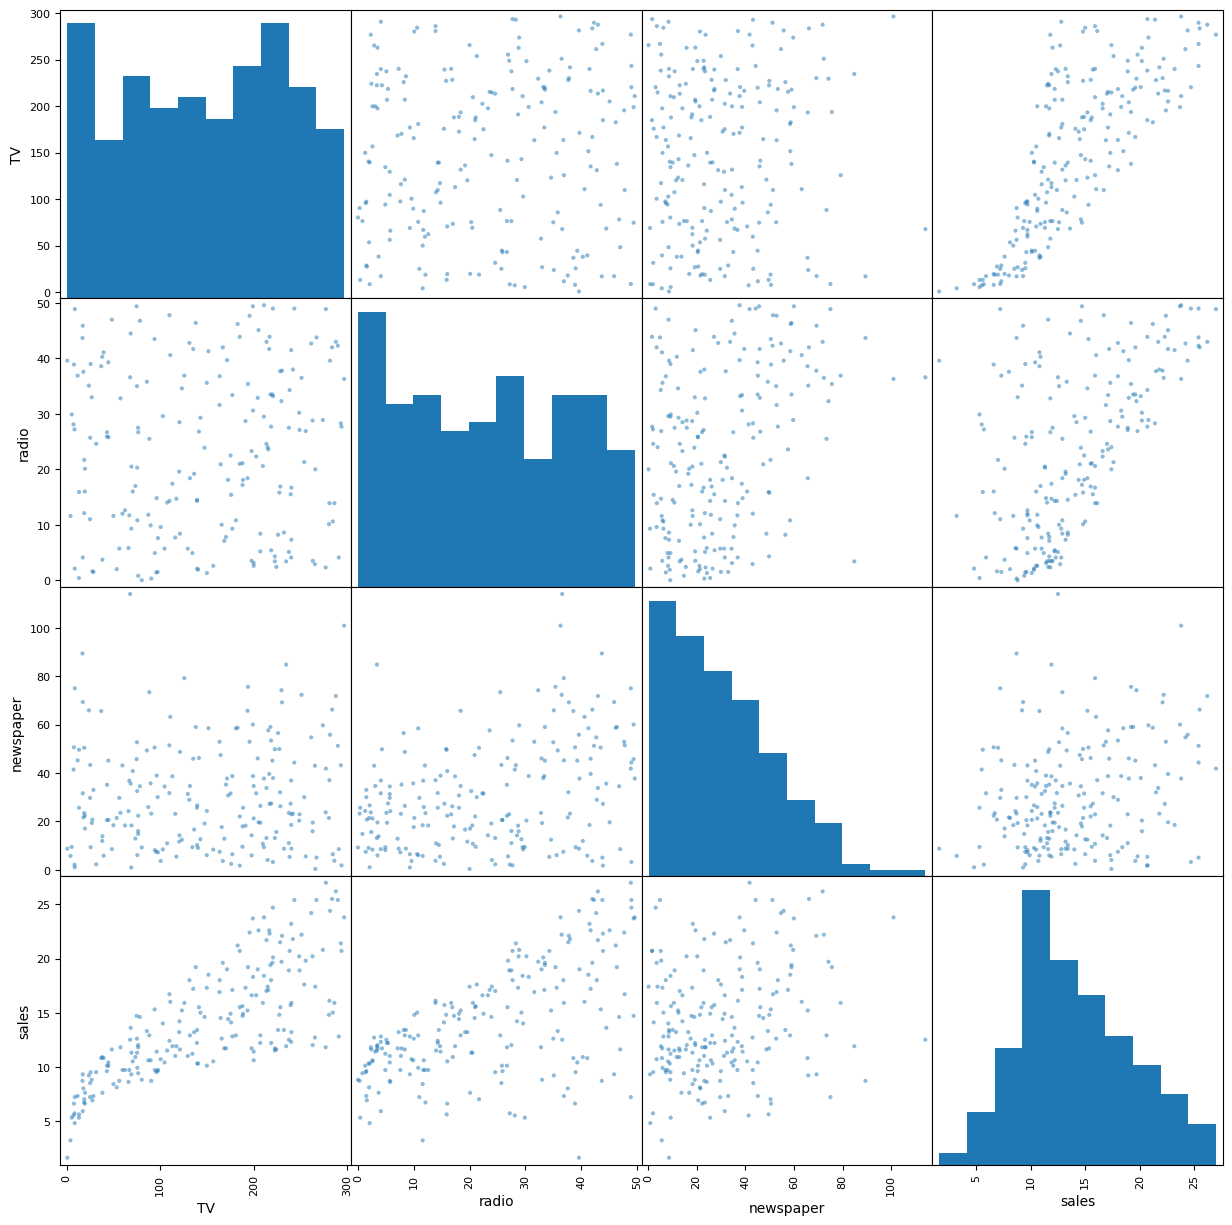

In [9]:
pd.plotting.scatter_matrix(ad, figsize=(15,15))
plt.show()

Wie bereits in der Vorlesung besprochen, sehen wir einen starken linearen Zusammenhang zwischen TV-Werbesausgaben und Sales. Diesen Zusammenhang werden wir nutzen, um ein erstes lineares Modell zu erzeugen.

Um Statsmodels hierfür zu nutzen, müssen wir unseren Daten zunächst eine Spalte mit dem Wert 1 hinzufügen, welche als $\beta_0$ genutzt wird.

## Datenvorbereitung

In [11]:
ad['intercept'] = 1

In [12]:
ad.head()

,TV,radio,newspaper,sales,intercept
1,230.1,37.8,69.2,22.1,1
2,44.5,39.3,45.1,10.4,1
3,17.2,45.9,69.3,9.3,1
4,151.5,41.3,58.5,18.5,1
5,180.8,10.8,58.4,12.9,1


Als nächstes initialisieren wir das Modell für die lineare Regression. Hierfür nutzen wir `OLS`, was für **O**rdinary **L**east **S**quares - Methode der kleinsten Quadrate steht. Dafür übergeben wir der Methode die Zielvariable und den Prädiktor TV, inklusive unserem Dummy Wert für $\beta_0$. 

## Modellierung

In [13]:
modTV = sm.OLS(ad.sales, ad.loc[:,['TV', 'intercept']])

In [14]:
modTV

Um die Parameter $\hat{\beta}_0$ und $\hat{\beta}_1$ zu schätzen rufen wir von unserem initialisierten Modell die Methode `fit` auf.

In [15]:
resTV = modTV.fit()

Die Parameter sind nun geschätzt und wir können uns die Zusammenfassung der Resultate anschauen.

In [16]:
resTV.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.47e-42
Time:                        14:00:23   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TV             0.0475      0.003     17.668      0.000       0.042       0.053
intercept      7.0326      0.458     15.360      0.000       6.130       7.935
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Als nächstes können wir unser Modell nutzen um Vorhersagen zu treffen. Hierfür nutzen wir die Methode `predict` und Plotten sie zusammen mit den bekannten Daten.

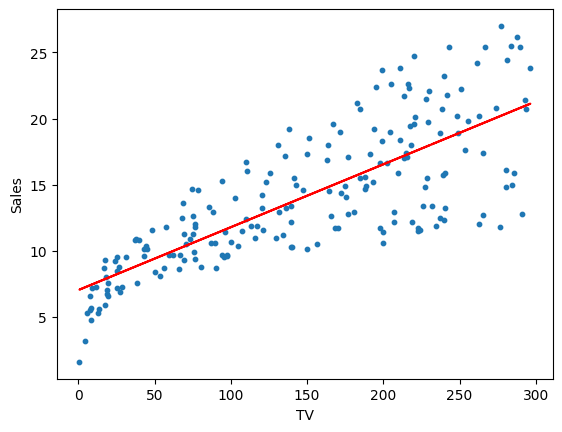

In [17]:
plt.scatter(ad.TV, ad.sales, s=10)
plt.plot(ad.TV, resTV.predict(ad.loc[:,['TV', 'intercept']]), c='red')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

Jetzt schauen wir uns das Modell mit allen Variablen an.

In [18]:
modAll = sm.OLS(ad.sales, ad.loc[:,['TV', 'radio', 'newspaper', 'intercept']])
resAll = modAll.fit()
resAll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           1.58e-96
Time:                        14:11:08   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
intercept      2.9389      0.312      9.422      0.000       2.324       3.554
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Wenn wir Interaktionen zwischen Variablen modellieren möchten, müssen wir diese in unserem Ausgangsdatensatz hinterlegen. Hierfür erzeugen wir neue Spalten, welche der Interaktion entsprechen. Der multiplikative Zusammenhang zwischen TV und radio wird wie folgt dargestellt.

In [19]:
ad['TVXradio'] = ad.TV * ad.radio

Diese neue Spalte können wir direkt in ein neues Modell aufnehmen.

In [20]:
modInter = sm.OLS(ad.sales, ad.loc[:,['TV', 'radio', 'TVXradio', 'intercept']])
resInter = modInter.fit()
resInter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          6.68e-146
Time:                        14:12:41   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TV             0.0191      0.002     12.699      0.000       0.016       0.022
radio          0.0289      0.009      3.241      0.001       0.011       0.046
TVXradio       0.0011   5.24e-05     20.727      0.000       0.001       0.001
intercept      6.7502      0.248     27.233      0.000       6.261       7.239
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Bias Variance Tradeoff

Mit diesem Datensatz können wir uns auch nochmals den Bias Variance Tradeoff ansehen. Dazu starten wir zunächst mit dem simplen Modell, mit dem der Umsatz nur durch die TV-Ausgaben vorhergesagt wird. Danach machen wir das Modell stetig flexibler (erhöhen sozusagen die Varianz) indem wir das Polynom um eine Ordnung erhöhen.

Entsprechend haben wir die Modelle:

TV_1: $y = \beta_0 + \beta_1 x$ \
TV_2: $y = \beta_0 + \beta_1 x + \beta_2 x^2$ \
TV_3: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$ \
...

Wir evaluieren wie gut die verschiedenen Modelle sind, indem wir $R^2$ auf Daten berechnen, die vorher nicht für das Training genutzt wurden.

180 of 200 datapoints used for training
TV_1 R2 Train: 0.585 | R2 Test: 0.753
TV_2 R2 Train: 0.589 | R2 Test: 0.775
TV_3 R2 Train: 0.592 | R2 Test: 0.777
TV_4 R2 Train: 0.592 | R2 Test: 0.779
TV_5 R2 Train: 0.597 | R2 Test: 0.799
TV_6 R2 Train: 0.589 | R2 Test: 0.806
TV_7 R2 Train: 0.506 | R2 Test: 0.707
TV_8 R2 Train: 0.062 | R2 Test: 0.466
TV_9 R2 Train: -0.160 | R2 Test: 0.302


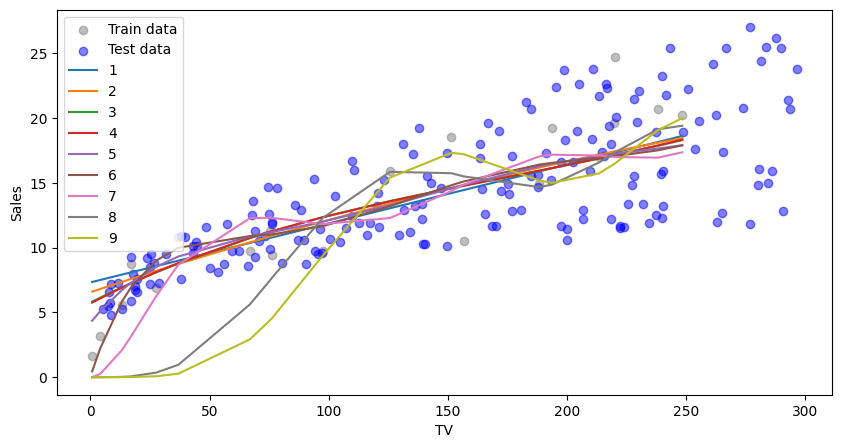

------------
100 of 200 datapoints used for training
TV_1 R2 Train: 0.694 | R2 Test: 0.523
TV_2 R2 Train: 0.694 | R2 Test: 0.518
TV_3 R2 Train: 0.708 | R2 Test: 0.507
TV_4 R2 Train: 0.709 | R2 Test: 0.503
TV_5 R2 Train: 0.717 | R2 Test: 0.516
TV_6 R2 Train: 0.715 | R2 Test: 0.492
TV_7 R2 Train: 0.644 | R2 Test: 0.357
TV_8 R2 Train: 0.056 | R2 Test: 0.169
TV_9 R2 Train: -0.205 | R2 Test: -0.010


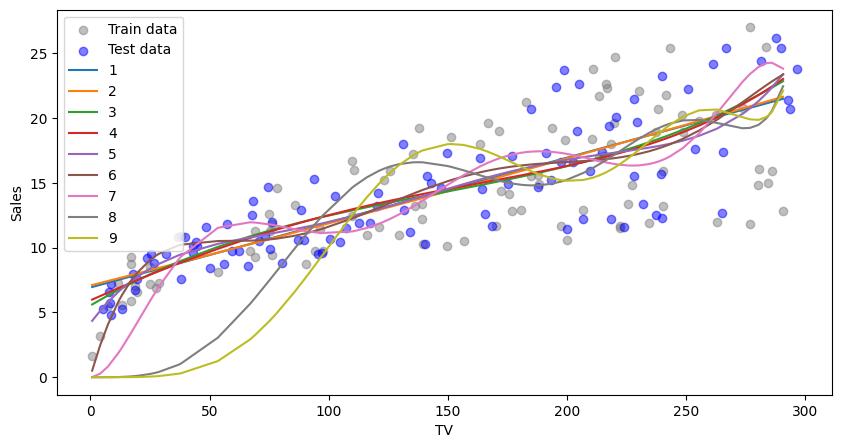

------------
20 of 200 datapoints used for training
TV_1 R2 Train: 0.676 | R2 Test: 0.602
TV_2 R2 Train: 0.690 | R2 Test: 0.569
TV_3 R2 Train: 0.793 | R2 Test: 0.480
TV_4 R2 Train: 0.805 | R2 Test: 0.462
TV_5 R2 Train: 0.805 | R2 Test: 0.461
TV_6 R2 Train: 0.839 | R2 Test: 0.405
TV_7 R2 Train: 0.782 | R2 Test: 0.262
TV_8 R2 Train: 0.285 | R2 Test: -0.102
TV_9 R2 Train: 0.118 | R2 Test: -0.300


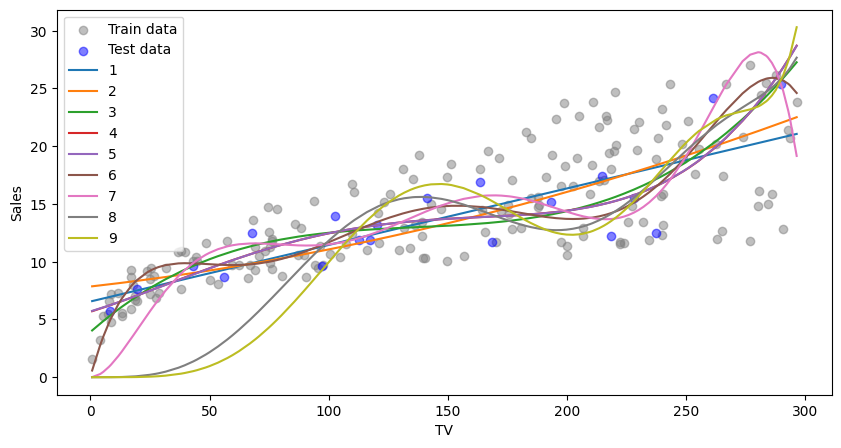

------------


In [21]:
import numpy as np
def r_squared(y_true, y_pred):
    # Calculate the mean of the actual values
    y_mean = np.mean(y_true)
    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)
    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)
    # Calculate R-squared
    return 1 - (rss / tss)   

# Loop through specific fraction of data
for n_frac in [0.9, 0.5, 0.1]:
    # Only use part of the data for training
    sampled = ad.sample(frac=n_frac, random_state=12)
    # Use the rest for testing
    not_sampled = ad.drop(sampled.index)
    
    # Initialize plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(not_sampled.TV, not_sampled.sales, color='grey', alpha=0.5, label='Train data')
    ax.scatter(sampled.TV, sampled.sales, color='blue', alpha=0.5, label='Test data')
    print(f'{int(n_frac*ad.shape[0])} of {ad.shape[0]} datapoints used for training')

    # Initialize model columns with "intercept" column
    model_columns = ['intercept']

    # Loop through polynomials of degree 1 to 9
    for i in range(1, 10):
        # Name of model
        col_name = f'TV_{i}'
        model_columns.append(col_name)
        # Add ith polynomial
        sampled[col_name] = sampled.TV ** i
        not_sampled[col_name] = not_sampled.TV ** i
        # Sort dataframe for plotting
        sampled = sampled.sort_values(by='TV', ascending=True)
        not_sampled = not_sampled.sort_values(by='TV', ascending=True)
        # Create model
        tmp_model = sm.OLS(sampled.sales, sampled.loc[:, model_columns])
        tmp_res = tmp_model.fit()
        # Output results
        # Predictions
        y_pred_test = tmp_res.predict(not_sampled.loc[:, model_columns])
        y_true_test = not_sampled.sales
        y_pred_train = tmp_res.predict(sampled.loc[:, model_columns])
        y_true_train = sampled.sales
        ax.plot(not_sampled.TV, y_pred_test, label=i)
        ax.set_xlabel('TV')
        ax.set_ylabel('Sales')
        r2_train = r_squared(y_true_train, y_pred_train)
        r2_test = r_squared(y_true_test, y_pred_test)
        print(f"{col_name} R2 Train: {r2_train:.3f} | R2 Test: {r2_test:.3f}")
    ax.legend()
    plt.show()
    
    print('------------')

## Auto Datensatz

Weiter machen wir mit dem Auto Datensatz von letzter Übung. Wir fügen auch hier direkt eine Spalte für $\beta_0$ hinzu.

In [23]:
auto = pd.read_csv('data/Auto_clean.csv')
auto['intercept'] = 1
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,intercept
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1


Bevor wir mit diesem Datensatz weiter arbeiten können, müssen wir Dummyvariablen für die qualitative Variable origin erstellen. Pandas stellt hierfür die Funktion `get_dummies` bereit, welche uns die händische Arbeit abnimmt. Mittels dem Parameter `drop_first` stellen wir ein, dass eine Variable weniger als die Anzahl der Ausprägungen hinzugefügt werden.

In [24]:
dummyVar = pd.get_dummies(auto.origin, prefix='origin', drop_first=True, dtype=int)
dummyVar

,origin_2,origin_3
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
387,0,0
388,1,0
389,0,0
390,0,0


Mithilfe von `concat` können wir die neuen Spalten dem alten Datensatz hinzufügen. Um sicherzugehen, dass die neuen Werte auch wirklich als Spalten (und nicht als Zeilen) hinzugefügt werden, übergeben wir den Parameter `axis=1`.

In [25]:
autoDum = pd.concat([auto, dummyVar], axis=1)
autoDum.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,intercept,origin_2,origin_3
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1,0,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1,0,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1,0,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1,0,0


Nun bauen wir ein Modell nur mit den Dummy Variablen mit dem Zielwert mpg.

In [26]:
modAutoOrig = sm.OLS(autoDum.mpg, autoDum.loc[:,["origin_2", "origin_3", "intercept"]])
resAutoOrig = modAutoOrig.fit()
resAutoOrig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     96.60
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           8.67e-35
Time:                        14:28:53   Log-Likelihood:                -1282.2
No. Observations:                 392   AIC:                             2570.
Df Residuals:                     389   BIC:                             2582.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
origin_2       7.5695      0.877      8.634      0.000       5.846       9.293
origin_3      10.4172      0.828     12.588      0.000       8.790      12.044
intercept     20.0335      0.409     49.025      0.000      19.230      20.837
==============================================================================
Omnibus:                       26.330   Durbin-Watson:                   0.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.217
Skew:                           0.679   Prob(JB):                     2.74e-07
Kurtosis:                       3.066   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

# Übungsaufgaben

## Aufgabe 1

Erstellen Sie eine einfach Regression mit Prädiktor **horsepower** und Zielwert **mpg** auf Basis des Auto-Datensatzes. Geben Sie sich die Zusammenfassung des Modells aus.
* Was fällt Ihnen auf? Zum Beispiel:
    * Gibt es einen Zusammenhang zwischen Prädiktor und Zielvariable?
    * Wie stark ist der Zusamenhang zwischen Prädiktor und Zielvariable?
    * Ist der Zusammenhang positiv oder negativ?
    * Was ist der vorhergesagte Wert von mpg für horsepower = 95?
* Plotten Sie die Regressionslinie und die zugrundeliegenden Daten in einem Plot.

In [29]:
auto = pd.read_csv('data/Auto_clean.csv')
auto['intercept'] = 1
modInter = sm.OLS(autoDum.horsepower, autoDum.loc[:,['mpg','intercept']])
resInter = modInter.fit()
resInter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             horsepower   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           7.03e-81
Time:                        14:40:58   Log-Likelihood:                -1804.2
No. Observations:                 392   AIC:                             3612.
Df Residuals:                     390   BIC:                             3620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mpg           -3.8389      0.157    -24.489      0.000      -4.147      -3.531
intercept    194.4756      3.873     50.211      0.000     186.861     202.091
==============================================================================
Omnibus:                       45.875   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.785
Skew:                           0.755   Prob(JB):                     4.26e-16
Kurtosis:                       4.434   Cond. No.                         78.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Mit signifianter Wahrscheinlichkeit besteht ein Zusammenhang zwischen den beiden.
* Der Koeffizient liegt bei ~-3.839
* Negativ da -
* -3.939 * 95 + 194.44756 = 157,39

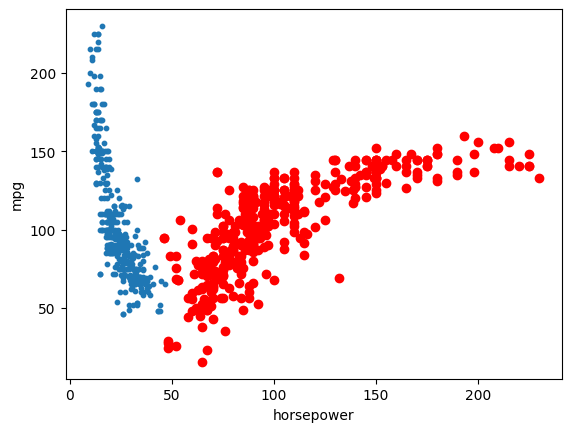

In [37]:
plt.scatter(auto.mpg, auto.horsepower, s=10)
#ad.TV, resTV.predict(ad.loc[:,['TV', 'intercept']]), c='red'
plt.scatter(autoDum.horsepower, resInter.predict(auto.loc[:,['mpg','intercept']]), c='red')
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()

In [41]:
auto = pd.read_csv('data/Auto_clean.csv')
auto['intercept'] = 1

In [42]:
autoMod = sm.OLS(auto.mpg, auto[['horsepower', 'intercept']])
autoRes = autoMod.fit()
autoRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           7.03e-81
Time:                        14:53:51   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
intercept     39.9359      0.717     55.660      0.000      38.525      41.347
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
autoRes.predict([95,1])

array([24.94061135])

Text(0, 0.5, 'mpg')

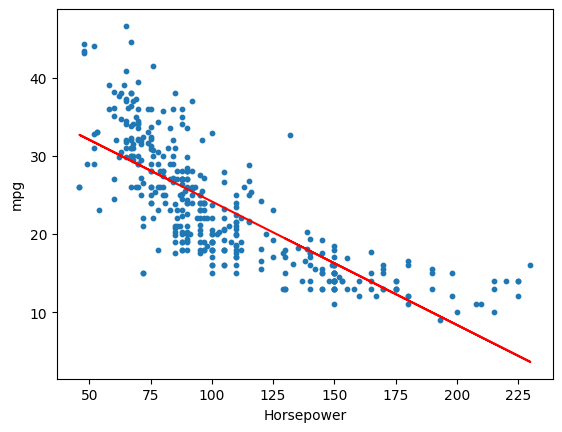

In [44]:
plt.scatter(auto.horsepower, auto.mpg, s=10)
plt.plot(auto.horsepower, autoRes.predict(auto[['horsepower', 'intercept']]), color='red')
plt.xlabel('Horsepower')
plt.ylabel('mpg')

## Aufgabe 2

Benutzen Sie wieder den Auto-Datensatz und **mpg** als Zielvariable.
* Erstellen Sie eine lineare Regression und nutzen Sie alle Variablen.
    * Gibt es einen Zusammenhang zwischen den Prädiktoren und der Zielvariable?
    * Welche Prädiktoren scheinen einen signifikanten Einfluss zu haben?
    * Was suggeriert der Koeffizient für Jahr?
* Schätzen Sie eine Regression mit Interaktionen (Multiplikation oder Division). Sind irgendwelche Interaktionen statistisch signifikant?
* Nutzen Sie andere Transformationen für die Variabeln in der Regression, z.B. $X^2, \log{(X)}, \sqrt{X}$. Beschreiben Sie ihre Erkenntnisse.

In [45]:
dummyVar = pd.get_dummies(auto.origin, prefix='origin', drop_first=True, dtype=int)
autoDum = pd.concat([auto, dummyVar], axis=1)

In [46]:
autoDum.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name', 'intercept', 'origin_2',
       'origin_3'],
      dtype='object')

In [47]:
autoAllMod = sm.OLS(autoDum.mpg, autoDum.drop(['mpg', 'name', 'origin'], axis=1))
autoAllRes = autoAllMod.fit()
autoAllRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          1.79e-139
Time:                        15:01:13   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cylinders       -0.4897      0.321     -1.524      0.128      -1.121       0.142
displacement     0.0240      0.008      3.133      0.002       0.009       0.039
horsepower      -0.0182      0.014     -1.326      0.185      -0.045       0.009
weight          -0.0067      0.001    -10.243      0.000      -0.008      -0.005
acceleration     0.0791      0.098      0.805      0.421      -0.114       0.272
year             0.7770      0.052     15.005      0.000       0.675       0.879
intercept      -17.9546      4.677     -3.839      0.000     -27.150      -8.759
origin_2         2.6300      0.566      4.643      0.000       1.516       3.744
origin_3         2.8532      0.553      5.162      0.000       1.766       3.940
==============================================================================
Omnibus:                       23.395   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.452
Skew:                           0.444   Prob(JB):                     3.30e-08
Kurtosis:                       4.150   Cond. No.                     8.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Displacement, horsepower, weight und acceleration haben nur einen sehr geringen Zusammenhang (0,1>)

* Cylinder kann H_0 nicht ausgeschlossen werden da 0 im Sig. Niveau drin ist -> H_0 kann nicht verworfen werden
* Displacement kann man H_0 ausschliesen, weil P < 0,05 (klein genug ist) und null nicht im Niveau ist. -> H_0 kann verworfen werden
* Horsepower ann H_0 nicht ausgeschlossen werden da 0 im Sig. Niveau drin ist und P > 0,05 -> H_0 kann nicht verworfen werden
* Weight kann man H_0 ausschliesen, weil P < 0,05 (klein genug ist) und null nicht im Niveau ist. -> H_0 kann verworfen werden
* Acceleration kann H_0 nicht ausgeschlossen werden da 0 im Sig. Niveau drin ist -> H_0 kann nicht verworfen werden
* Year kann man H_0 ausschliesen, weil P < 0,05 (klein genug ist) und null nicht im Niveau ist. -> H_0 kann verworfen werden

Für jedes zusätzliche Jahr, steigt der mpg um 0.7770

In [48]:
autoDum['CylinderXDisplacement'] = autoDum.cylinders * autoDum.displacement
autoDum['DisplacementXWeight'] = autoDum.displacement * autoDum.weight
autoInterMod = sm.OLS(
    autoDum.mpg,
    autoDum[['CylinderXDisplacement', 'DisplacementXWeight', 'cylinders', 'weight', 'displacement', 'intercept']]
)
autoInterRes = autoInterMod.fit()
autoInterRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     205.8
Date:                Thu, 25 Jan 2024   Prob (F-statistic):          1.63e-106
Time:                        15:20:38   Log-Likelihood:                -1106.6
No. Observations:                 392   AIC:                             2225.
Df Residuals:                     386   BIC:                             2249.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CylinderXDisplacement    -0.0030      0.003     -0.872      0.384      -0.010       0.004
DisplacementXWeight    2.128e-05      5e-06      4.254      0.000    1.14e-05    3.11e-05
cylinders                 0.7606      0.767      0.992      0.322      -0.747       2.269
weight                   -0.0099      0.001     -7.438      0.000      -0.013      -0.007
displacement             -0.0735      0.017     -4.403      0.000      -0.106      -0.041
intercept                52.6234      2.237     23.519      0.000      48.224      57.023
==============================================================================
Omnibus:                       57.314   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.792
Skew:                           0.814   Prob(JB):                     8.75e-25
Kurtosis:                       5.033   Cond. No.                     9.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* CylinderXDisplacement nicht signifikant
* DisplacementXWeight ist signifkant
--> Rest gleich

In [49]:
autoDum['horsepower2'] = auto.horsepower * auto.horsepower
autoHP2Mod = sm.OLS(autoDum.mpg, autoDum[['horsepower', 'horsepower2', 'intercept']])
autoHP2Res = autoHP2Mod.fit()
autoHP2Res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           5.40e-99
Time:                        15:22:03   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001
intercept      56.9001      1.800     31.604      0.000      53.360      60.440
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* Ist signifkant, aber Koeffizient sehr gering

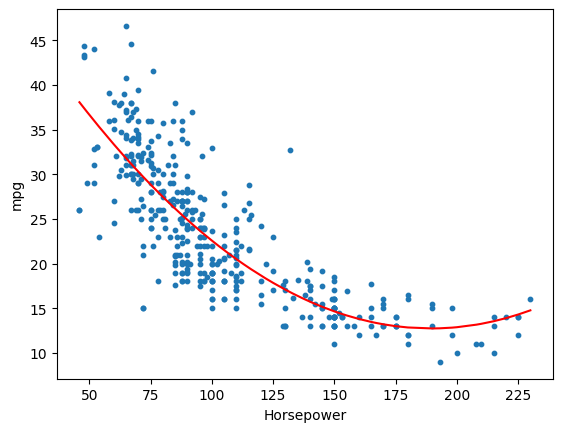

In [50]:
plt.scatter(autoDum.horsepower, autoDum.mpg, s=10)
plt.plot(
    autoDum.sort_values(by='horsepower').horsepower,
    autoHP2Res.predict(autoDum[['horsepower', 'horsepower2', 'intercept']].sort_values(by='horsepower')),
    color='red'
)
plt.xlabel('Horsepower')
plt.ylabel('mpg')
plt.show()

--> Durch quadratischen Variable kann das Modell besser gefittet werden.